## Vehicle detection

In [1]:
#Initialization
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Function import_data()
#### Read in vehicles and non-vehicles and return two arrays

In [2]:
# Read in our vehicles and non-vehicles
def import_data():
    cars = []
    not_cars = []

    car_images = glob.glob('./vehicles/*/*.png')
    not_car_images = glob.glob('./non-vehicles/*/*.png')

    #print('car_images: ' + str(len(car_images)))
    #print('not_car_images: ' + str(len(not_car_images)))

    for image in car_images:
        cars.append(image)
    for image in not_car_images:
        not_cars.append(image)

    
    return cars, not_cars

print('...')

...


### Test import_data()

In [3]:
cars, not_cars = import_data()
print('cars: ' + str(len(cars)))
print('not_cars: ' + str(len(not_cars)))


cars: 8792
not_cars: 8968


### Explore color spaces

...


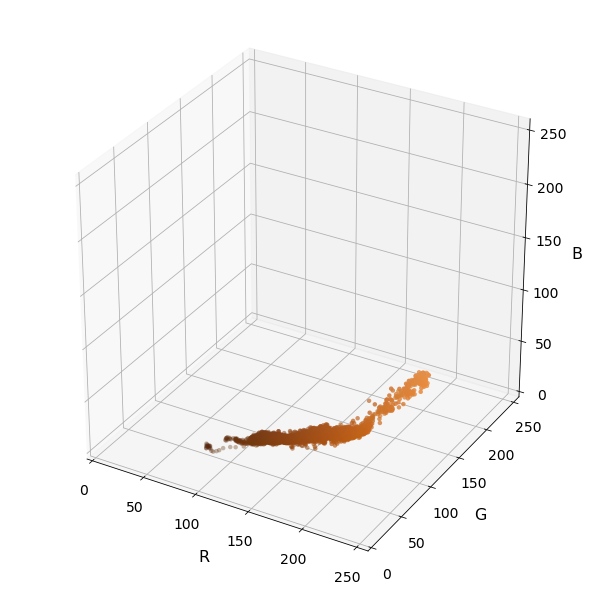

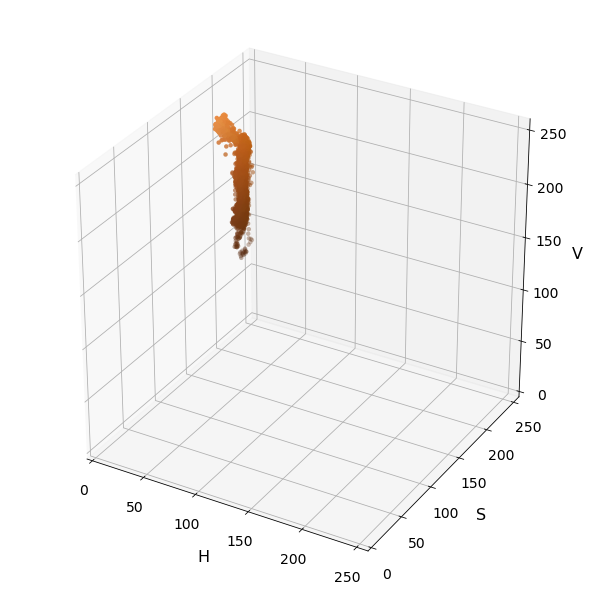

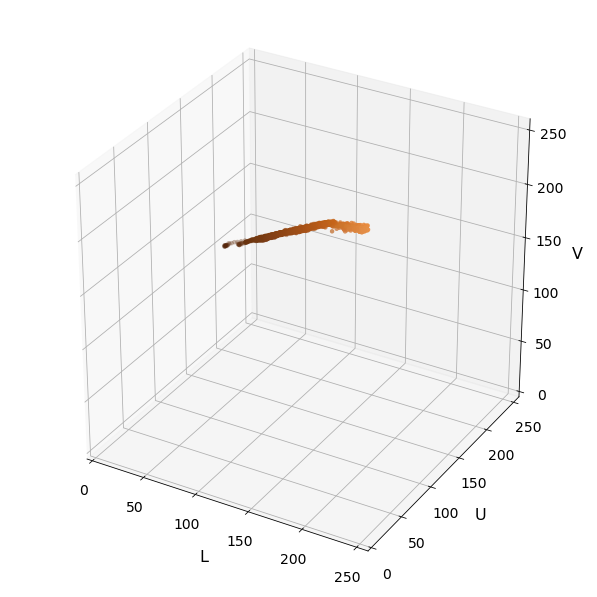

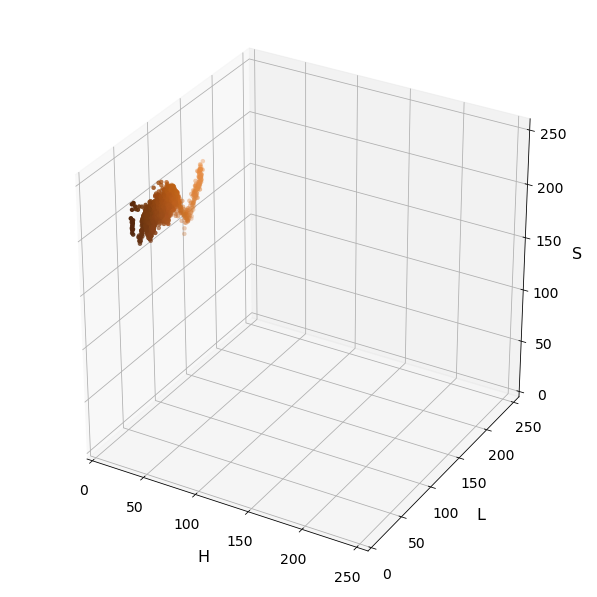

In [4]:

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

print('...')

# Read a color image
img = cv2.imread("./test_images/8.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.show()


### Function bin_spatial(...)
#### Define a function to compute color histogram features.
#### Pass the color_space flag as 3-letter all caps string like 'HSV' or 'LUV' etc.


In [5]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

print('...')

...


### Test function bin_spatial(...)

In [6]:
# Read a color image
img = cv2.imread("./test_images/8.png")

features = bin_spatial(img, size=(32, 32))
print(len(features))

3072


### Function color_hist(...)
#### Called from function extract_features(...)
##### Compute color histogram features  

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

print('...')

...


### Function get_hog_feature(...)
### Used in the pipeline, called from function extract_features()
#### Function to return HOG features and visualization
##### Uses skimage.feature.hog. If param vis == True, a visualization is also returned

In [8]:
# Dalal, N, Finding People in Images and Videos, Human-Computer Interaction [cs.HC],
#   Institut National Polytechnique de Grenoble - INPG, 2006, 
#   https://tel.archives-ouvertes.fr/tel-00390303/file/NavneetDalalThesis.pdf
#   p48: "For cars all four combinations (RGB/√RGB + L1-Sqrt/L2-Hys) give similar results,
#           with √RGB and L1-Sqrt having a slight edge."
# But since L1-sqrt is deprecated in skimage, L2-Hys is used

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=True, 
                          visualise=vis, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=True, 
                          visualise=vis, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return features

print('...')

...


### Test of function get_hog_features(...)

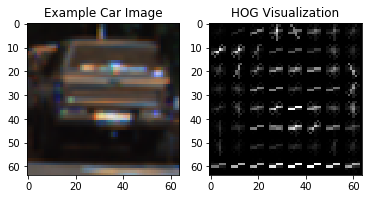

In [9]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = cv2.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
fig.add_subplot(121)
plt.title('Example Car Image')
plt.imshow(image, cmap='gray')
fig.add_subplot(122)
plt.title('HOG Visualization')
plt.imshow(hog_image, cmap='gray')


### Data normalization

### Function feature_vector(...)
#### Input : feature_list = (car_vector, notcar_vector) - the order is important.

In [10]:
def feature_vector(feature_list):
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    X = np.vstack(feature_list).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(feature_list[0])), np.zeros(len(feature_list[1]))))

    return X, scaled_X, y

print('...')

...


### Function convert_color(...)

In [11]:
def convert_color(image, color_space):
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    return feature_image

print('...')

...


### Function extract_c_h_features(...)
#### Extract only spatial color features and color histograms

In [12]:
def extract_c_h_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate througn the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = convert_color(image, color_space)
        else: feature_image = np.copy(image)      

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    return features

print('...')

...


### Function extract_hog_features(...)

In [13]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = convert_color(image, color_space)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

print('...')

...


### Function extract_features
#### extract color space features, color histogram features, and HOG features
#### This function is used in the pipeline.

In [14]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        # if read with cv2, then it is BGR format, not the RGB format
        #image = cv2.imread(file)
        # the images are png and read with mpimg.imread(), so they must be conv from [0..1]float to [0..255]int8
        image = mpimg.imread(file)
        image = image * 255
        image = image.astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_color(image, color_space)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            #spatial_features = bin_spatial(feature_image, size=spatial_size)
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

print('...')

...


### Extract features from cars and non cars

In [15]:
car_features = extract_features(cars, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32)
notcar_features = extract_features(not_cars, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32)

### Test

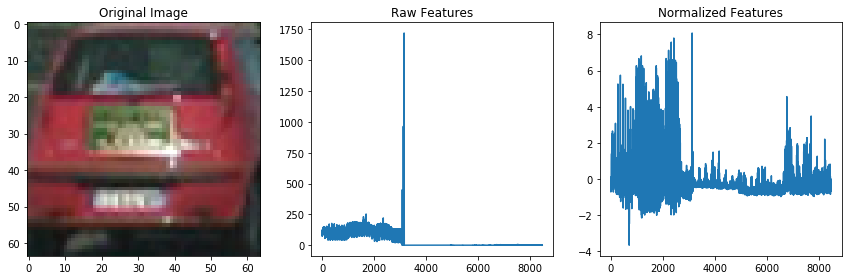

In [16]:

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### Function extract_and_scale_all_features(...)

In [17]:
def extract_and_scale_all_features(color_space='YCrCb', hist=32, spat=32):
    car_features = extract_features(cars, color_space, spatial_size=(spat, spat),
                        hist_bins=hist)
    notcar_features = extract_features(not_cars, color_space, spatial_size=(spat, spat),
                        hist_bins=hist)
    X, scaled_X, y = feature_vector((car_features, notcar_features))
    return X, scaled_X, y

print('...')

...


### test extract_and_scale_all_features(...)

In [ ]:
Do not run this block

spatial = 32
histbin = 32
X, scaled_X, y = extract_and_scale_all_features(color_space='YCrCb', hist=histbin, spat=spatial)
if len(scaled_X) > 0:
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### Test extract_features()

In [ ]:
Do not run this block

spatial = 32
histbin = 32
# Check the extraction time
t=time.time()
car_features = extract_features(cars, color_space='LUV', spatial_size=(spatial,spatial), hist_bins=histbin)
notcar_features = extract_features(not_cars, color_space='LUV', spatial_size=(spatial,spatial), hist_bins=histbin)
X, scaled_X, y = feature_vector((car_features, notcar_features))
t2 = time.time()
print(round(t2-t, 2), 'seconds to extract_features...')

### Train

In [18]:
# Extract features and train a linear SVC
spatial = 32
histbin = 32
color_space='YCrCb' #'LUV'

# Check the extraction time
t=time.time()
print('Start time:', round(t,2))
#X, scaled_X, y = extract_and_scale_all_features(color_space='LUV', hist=histbin, spat=spatial)

car_features = extract_features(cars, color_space=color_space, spatial_size=(spatial,spatial), hist_bins=histbin)
notcar_features = extract_features(not_cars, color_space=color_space, spatial_size=(spatial,spatial), hist_bins=histbin)
X, scaled_X, y = feature_vector((car_features, notcar_features))
X_scaler = StandardScaler().fit(X)

t2 = time.time()
print(round(t2-t, 2), 'seconds to extract_features...')
print('...')

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using colorspace:',color_space)
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Start time: 1516552173.48
565.97 seconds to extract_features...
...
Using colorspace: YCrCb
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460
128.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  1.  1.]
0.41713 Seconds to predict 10 labels with SVC


In [19]:
#save a copy of the LUC model
svc_YCrCb = svc
#X_scaler = StandardScaler().fit(X)


### ...

### Function draw_boxes(...)

In [20]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


### Function slide_window(...)
#### Input:  image, start and stop positions in both x and y, window size (x and y dimensions),  and overlap fraction (for both x and y)


In [21]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

print('...')

...


### test slide_window(...)

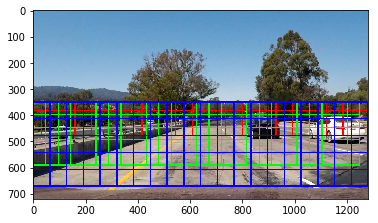

In [50]:
image = mpimg.imread('./test_images/test1.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 500], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(255, 0, 0), thick=3)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 600], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(window_img, windows, color=(0, 255, 0), thick=3)   

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=3)   

plt.imshow(window_img)

### Function single_img_features(...)
#### Extract features from a single image window.
#### This function is very similar to extract_features(), but just for a single image rather than list of images


In [25]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_color(img, color_space)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

print('...')

...


### Function search_windows(...)
#### Define a function you will pass an image and the list of windows to be searched (output of slide_windows())


In [26]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #print(len(features))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

print('...')

...


### Function find_cars(...)
#### Extracts features using hog sub-sampling and make predictions


In [27]:
def find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Create an empty list to receive positive test_detection bboxes
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list

print('...')

...


### Functions add_heat(...) and apply_threshold(...)

In [28]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# ---

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('...')

# Remember to call the last heatmap with: labels = label(heatmap) to get

...


### Function draw_labeled_bboxes(...)

In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

print('...')

...


### Test workflow on a single test image

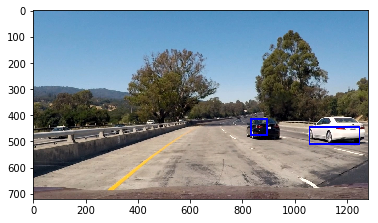

In [31]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 700] # Min and max in y to search in slide_window()
scale = 1.5
threshold=1

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

on_windows = search_windows(image, windows, clf=svc, scaler=X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(image, on_windows, color=(0, 0, 255), thick=6)                    
#plt.imshow(window_img)

heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, on_windows)
heatmap = apply_threshold(heatmap, threshold)
labels = label(heatmap)

images_w_boxes = draw_labeled_bboxes(draw_image, labels)
plt.imshow(images_w_boxes)

### Single image test with function find_cars()

In [64]:
def process_one_image(image):
    draw_image = np.copy(image)
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [350, 700] # Min and max in y to search in slide_window()
    scales = (1.0, 1.5, 2.0)
    bboxes = []
    threshold=7
    
    #image = convert_color(image, color_space)
    for s in scales:
        find_cars_image, bbox_list = find_cars(image, color_space=color_space, ystart=y_start_stop[0], ystop=y_start_stop[1],
                             scale=s, svc=svc, X_scaler=X_scaler,
                             orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                             spatial_size=spatial_size, hist_bins=hist_bins)
        bboxes.append(bbox_list)

    #print('len bboxes:', len(bboxes))
    # apparently this is the best way to flatten a list of lists
    rects = [item for sublist in bboxes for item in sublist]
    #print(rects)
    #return draw_image
    #return find_cars_image
    
    zero_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    current_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    current_heatmap = add_heat(current_heatmap, rects)
    #color_heatmap = np.dstack((current_heatmap, zero_heatmap, zero_heatmap))
    #return color_heatmap
    heatmaps.append(current_heatmap)
    if len(heatmaps) == 5:
        sum_heatmap = sum(heatmaps)
        avg_heatmap = sum_heatmap/len(heatmaps)
        heatmap = apply_threshold(avg_heatmap, threshold)
        labels = label(heatmap)
    else:
        #return current_heatmap
        heatmap = apply_threshold(current_heatmap, 7)
        return heatmap
        #color_heatmap = np.dstack((heatmap, zero_heatmap, zero_heatmap))
        #return color_heatmap
        labels = label(heatmap)
    return draw_labeled_bboxes(draw_image, labels)
    
print('...')

...


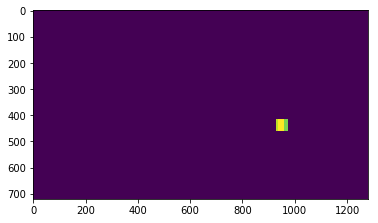

In [65]:
heatmaps = deque(maxlen=5)
#image = cv2.imread('./test_images/test1.jpg')
image = mpimg.imread('./test_images/video_frame_21s.jpg')
image_w_boxes = process_one_image(image)
plt.imshow(image_w_boxes)

### Function *write_video()* to create a new annotated video
#### Used in the calls below

In [47]:
def write_video(in_fname, out_fname):
    output_video = out_fname
    #clip1 = VideoFileClip(\"test_videos/solidWhiteRight.mp4\").subclip(4,9)
    input_clip = VideoFileClip(in_fname)#.subclip(16,22)
    output_clip = input_clip.fl_image(process_one_image) #NOTE: this function expects color images!!
    %time output_clip.write_videofile(output_video, audio=False)


### Run pipeline on *test_video.mp4*

In [48]:
heatmaps = deque(maxlen=5)
write_video('test_video.mp4', './output_images/test_video_w_detections.mp4')

[MoviePy] >>>> Building video ./output_images/test_video_w_detections.mp4
[MoviePy] Writing video ./output_images/test_video_w_detections.mp4


 97%|█████████▋| 38/39 [03:42<00:05,  5.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video_w_detections.mp4 

CPU times: user 3min 38s, sys: 7.23 s, total: 3min 45s
Wall time: 3min 44s


### Run pipeline on *project_video.mp4*

In [49]:
heatmaps = deque(maxlen=5)
write_video('project_video.mp4', './output_images/project_video_w_detections.mp4')

[MoviePy] >>>> Building video ./output_images/project_video_w_detections.mp4
[MoviePy] Writing video ./output_images/project_video_w_detections.mp4


100%|█████████▉| 1260/1261 [2:03:17<00:05,  5.85s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_w_detections.mp4 

CPU times: user 2h 56s, sys: 4min 2s, total: 2h 4min 59s
Wall time: 2h 3min 18s
